In [1]:
import numpy as np
import pandas as pd
import os
import random
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam


In [2]:
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
Ravdees = r"dataset/audio_speech_actors_01-24/"

In [4]:
ravdees_directory_list = os.listdir(Ravdees)
file_emotion = []
file_statement = []
file_path = []

In [5]:
for dir in ravdees_directory_list:
    actor = os.listdir(Ravdees+dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdees + dir + '/' + file)

Ravdees_df = pd.DataFrame({
    "Emotion" : file_emotion,
    "Statement" : file_statement,
    "Path" : file_path
})


Ravdees_df.Emotion.replace(
    {
        1: 'neutral',
        2: 'neutral',
        3: 'happy',
        4: 'sad',
        5: 'angry',
        6: 'fear',
        7: 'disgust',
        8: 'surprise'
    },
    inplace=True
)

Ravdees_df = Ravdees_df[~Ravdees_df["Emotion"].isin(['fear', 'disgust'])]

In [6]:
Ravdees_df.head()

Emotion  Statement                                               Path
0  neutral          1  dataset/audio_speech_actors_01-24/Actor_01/03-...
1  neutral          1  dataset/audio_speech_actors_01-24/Actor_01/03-...
2  neutral          2  dataset/audio_speech_actors_01-24/Actor_01/03-...
3  neutral          2  dataset/audio_speech_actors_01-24/Actor_01/03-...
4  neutral          1  dataset/audio_speech_actors_01-24/Actor_01/03-...

In [7]:
Ravdees_df.shape

(1056, 3)

In [8]:
Ravdees_df.groupby(['Emotion', 'Statement']).size().unstack()

Statement    1    2
Emotion            
angry       96   96
happy       96   96
neutral    144  144
sad         96   96
surprise    96   96

In [9]:
data_path = Ravdees_df[['Emotion', 'Path']].copy()
data_path.to_csv("data_path.csv", index=False)
data_path.head()

Emotion                                               Path
0  neutral  dataset/audio_speech_actors_01-24/Actor_01/03-...
1  neutral  dataset/audio_speech_actors_01-24/Actor_01/03-...
2  neutral  dataset/audio_speech_actors_01-24/Actor_01/03-...
3  neutral  dataset/audio_speech_actors_01-24/Actor_01/03-...
4  neutral  dataset/audio_speech_actors_01-24/Actor_01/03-...

In [10]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title("Waveplot for Audio", size=15)
    librosa.display.waveshow(data)
    plt.show()

def create_spectrogram(data, sr):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title("Spectogram for Audio", size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

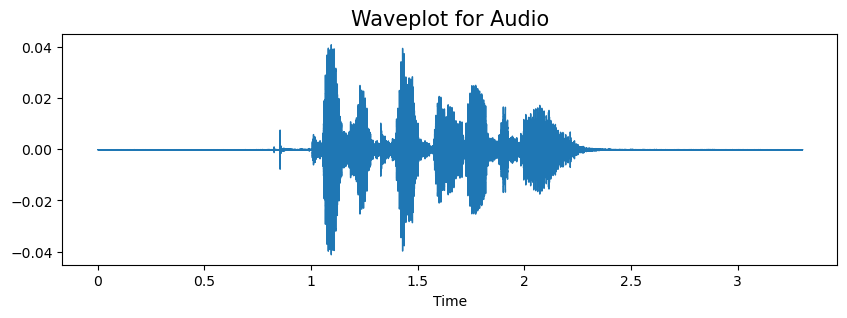

In [11]:
path = r"dataset\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

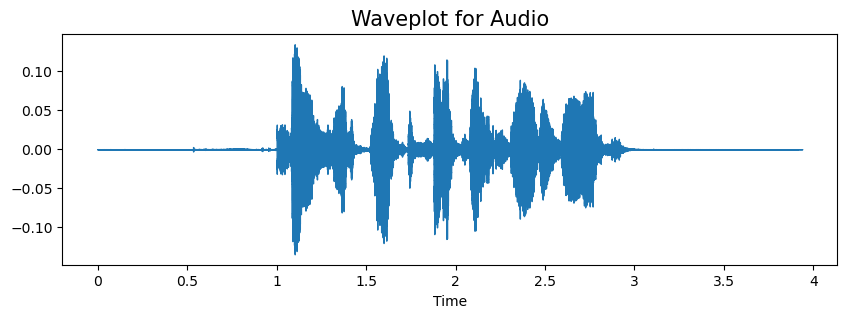

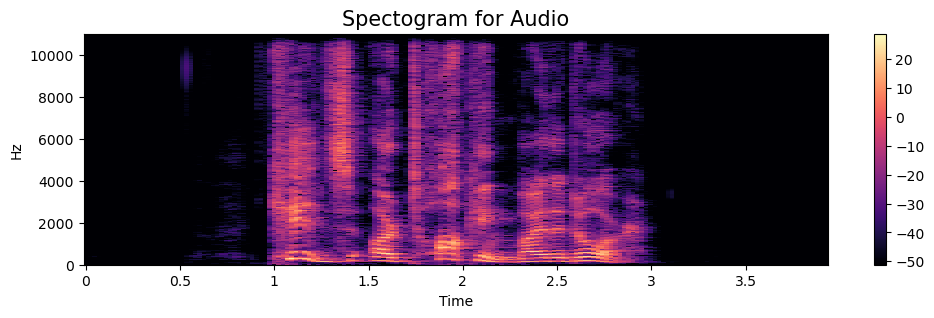

In [12]:
emotion = 'angry'
path = np.array(data_path.Path[data_path.Emotion == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

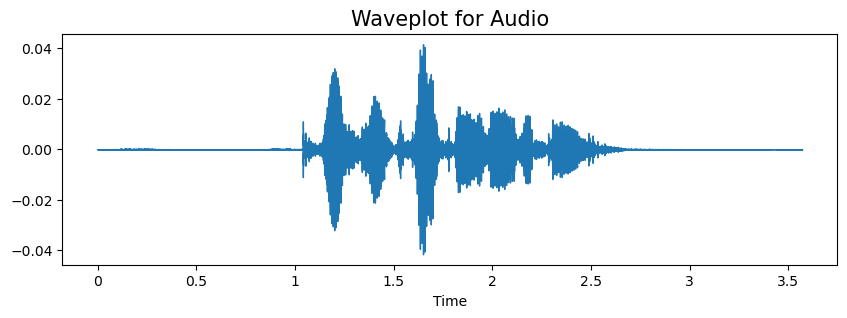

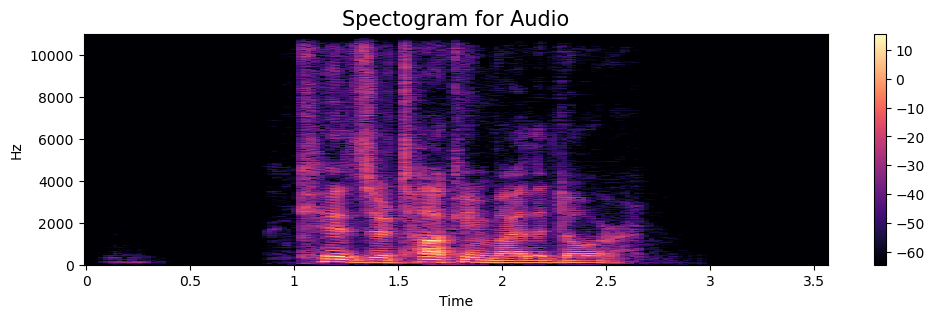

In [13]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

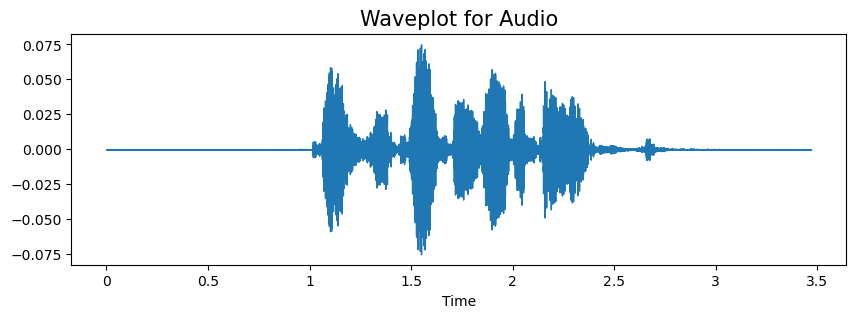

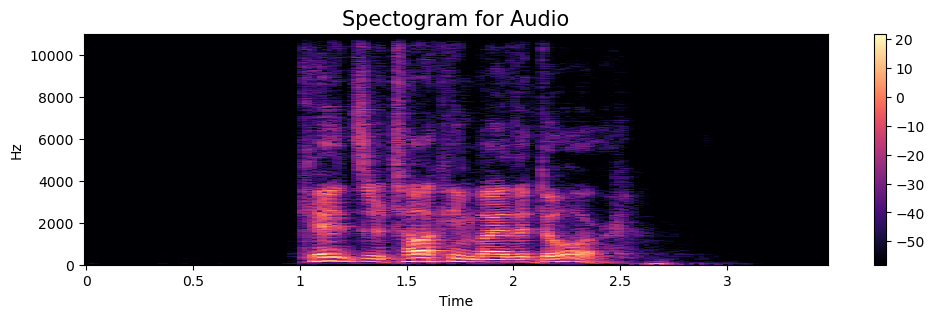

In [14]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

In [15]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.85):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps=pitch_factor)

In [16]:
path = np.array(data_path.Path)[1]
data, sampling_rate = librosa.load(path)

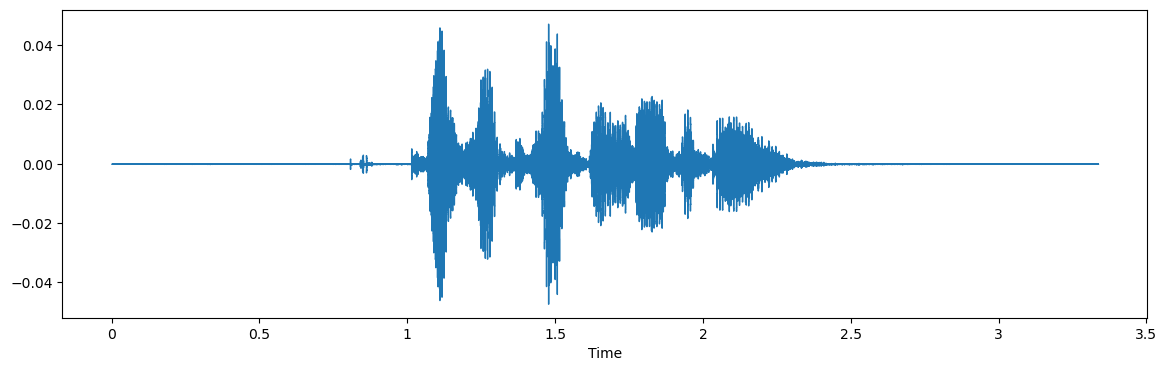

In [17]:
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sampling_rate)

In [18]:
Audio(path)

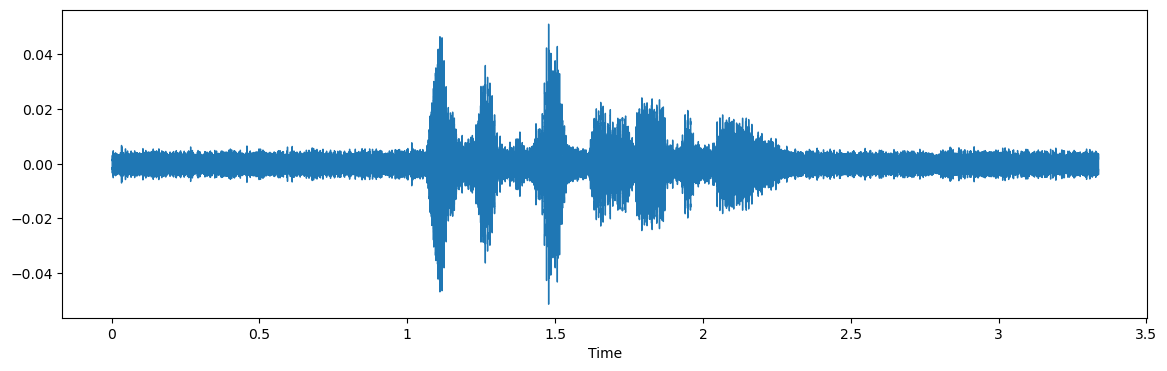

In [19]:
## Noise Injection
x = noise(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

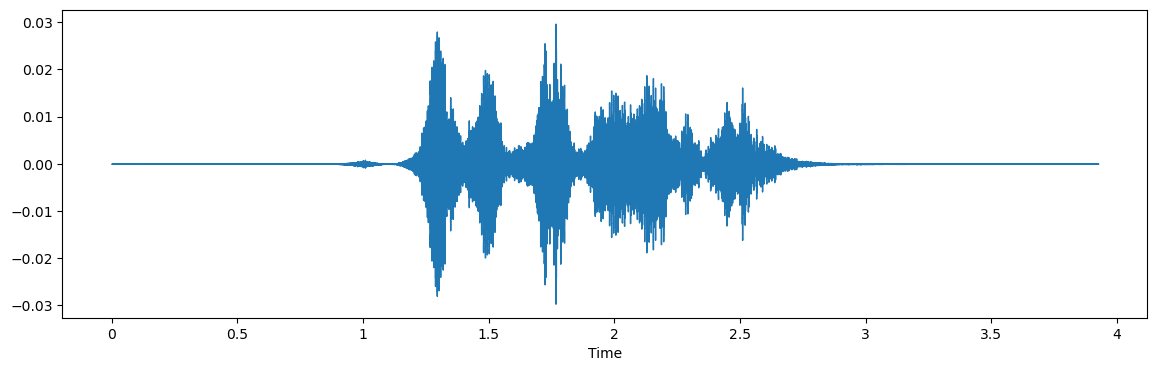

In [20]:
## Strecth Injection
x = stretch(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)


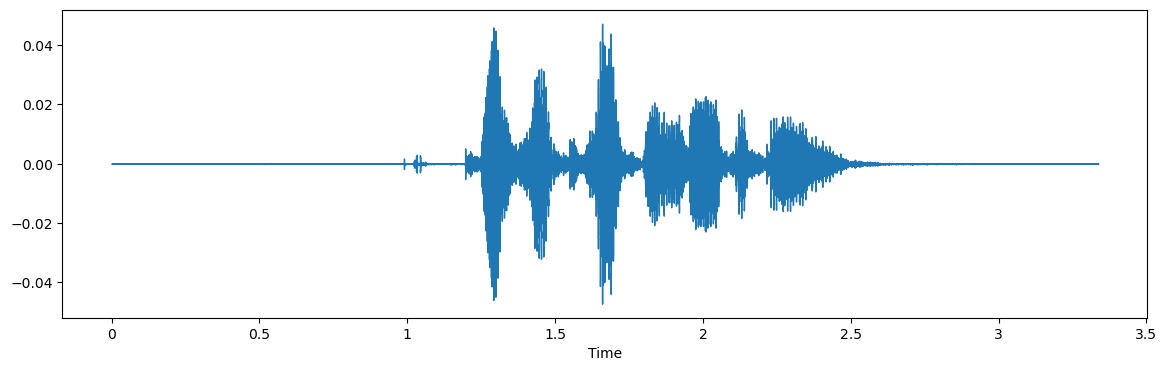

In [21]:
## Shift
x = shift(data)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

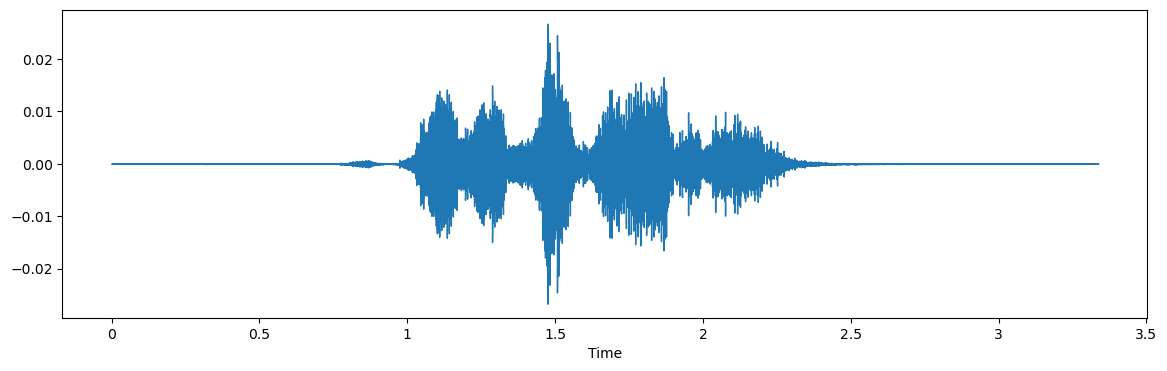

In [22]:
## Pitch 
x = pitch(data, sampling_rate)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [23]:
def extract_features(data):
    mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate)
    result = mfcc
    return result

def transform_audio(data, fns):
    fn = random.choice(fns)
    if fn == pitch:
        fn_data = fn(data, sampling_rate)
    elif fn == "None":
        fn_data = data
    elif fn in [noise, stretch]:
        fn_data = fn(data)
    else:
        fn_data = data
    return fn_data

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
    fns = [noise, pitch, "None"]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data)
    result = [np.array(res1[:, :108])]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data)[:, :108]
    result.append(res2)

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data)[:, :108]
    result.append(res3)

    return result

In [24]:
path = r"dataset\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path, duration=2.5, offset=0.6)
Audio(path)
xx1 = librosa.feature.zero_crossing_rate(data)
stft = np.abs(librosa.stft(data))
xx2 = librosa.feature.chroma_stft(S=stft, sr=sampling_rate)
xx3 = librosa.feature.mfcc(y=data, sr=sampling_rate)
xx4 = librosa.feature.rms(y=data)
xx5 = librosa.feature.melspectrogram(y=data, sr=sampling_rate)
xx1.shape, xx2.shape, xx3.shape, xx4.shape, xx5.shape, np.append(xx1, xx2, axis=0).shape

((1, 108), (12, 108), (20, 108), (1, 108), (128, 108), (13, 108))

In [25]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotion.to_list()):
    feature = get_features(path)
    for ele in feature:
        if ele.shape == (20, 108):
            X.append(ele)
            Y.append(emotion)
        else:
            print(ele.shape)

(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 103)
(20, 103)
(20, 103)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 107)
(20, 101)
(20, 101)
(20, 101)
(20, 104)
(20, 104)
(20, 104)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 105)
(20, 107)
(20, 107)
(20, 107)


In [26]:
len(X), len(Y), data_path.Path.shape

(3129, 3129, (1056,))

In [27]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [28]:
Features = dfm.copy()
Features['labels'] = Y
Features.head()
Features.to_csv('features.csv', index=False)

In [29]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((3129, 20, 108), (3129,))

In [30]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2503, 20, 108), (2503, 5), (626, 20, 108), (626, 5))

In [32]:
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

In [33]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2503, 108, 20, 1, 1), (2503, 5), (626, 108, 20, 1, 1), (626, 5))

In [34]:
input_shape = x_train.shape[1:]
input_shape

(108, 20, 1, 1)

In [35]:
model = Sequential([
    TimeDistributed(Conv1D(32, 3, padding='same', activation='relu'), input_shape=input_shape),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Dropout(0.2)),
    TimeDistributed(Conv1D(64, 3, padding='same', activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(Dropout(0.3)),
    TimeDistributed(Flatten()),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(units=5, activation='softmax')
])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 108, 20, 1, 32)   128       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 108, 20, 1, 32)   128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 108, 20, 1, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 108, 20, 1, 64)   6208      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 108, 20, 1, 64)   2

In [36]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
)

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.000001)
epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
20/20 [==============================] - 13s 153ms/step - loss: 1.5672 - accuracy: 0.2641 - val_loss: 1.6450 - val_accuracy: 0.2827 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 2s 78ms/step - loss: 1.4205 - accuracy: 0.3903 - val_loss: 1.7266 - val_accuracy: 0.3275 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 2s 79ms/step - loss: 1.3780 - accuracy: 0.4179 - val_loss: 1.5143 - val_accuracy: 0.3786 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 2s 77ms/step - loss: 1.2733 - accuracy: 0.4602 - val_loss: 1.5187 - val_accuracy: 0.3898 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 2s 78ms/step - loss: 1.2744 - accuracy: 0.4634 - val_loss: 1.5109 - val_accuracy: 0.3978 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 2s 77ms/step - loss: 1.2475 - accuracy: 0.4846 - val_loss: 1.4591 - val_accuracy: 0.4489 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 2s 80ms/step - 

20/20 [==============================] - 1s 21ms/step - loss: 0.6015 - accuracy: 0.8450
Accuracy of our model on test data :  84.50479507446289 %


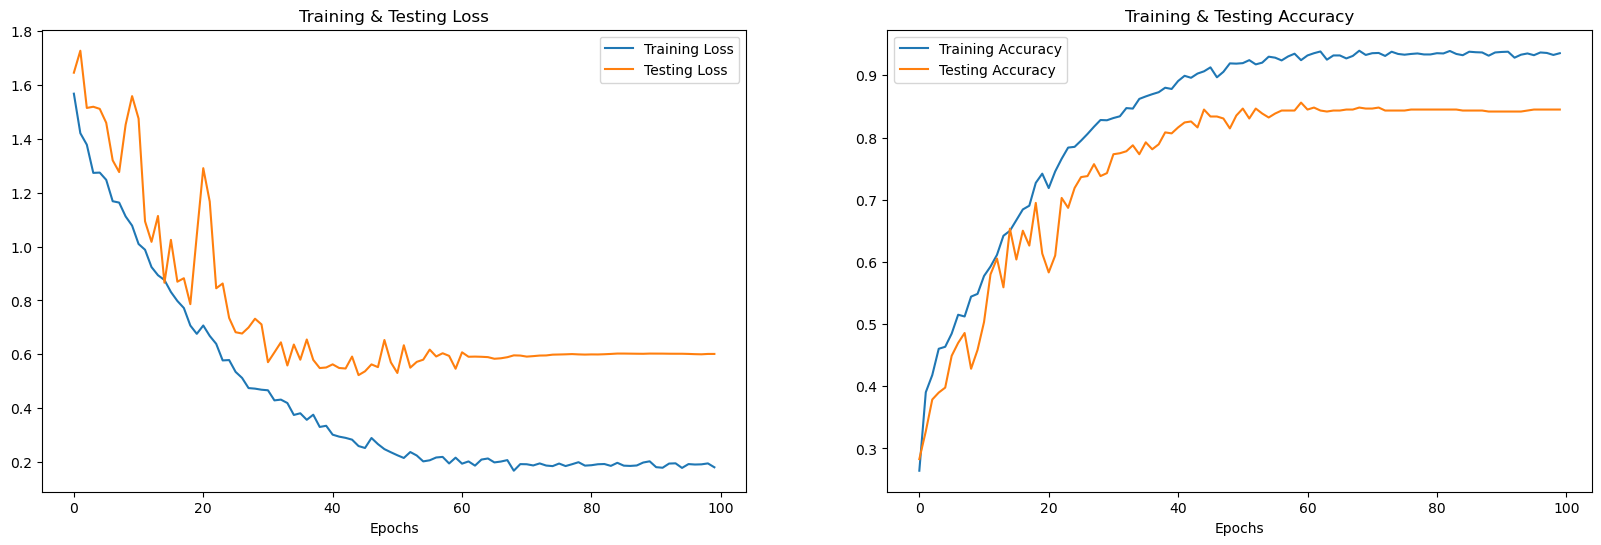

In [37]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [38]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

20/20 [==============================] - 1s 19ms/step


In [39]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(30)

Predicted Labels Actual Labels
0          surprise      surprise
1           neutral       neutral
2          surprise         happy
3           neutral           sad
4             angry         angry
5          surprise       neutral
6          surprise      surprise
7          surprise      surprise
8           neutral           sad
9          surprise      surprise
10            angry         angry
11              sad       neutral
12            angry         angry
13            happy         happy
14          neutral       neutral
15            happy         happy
16              sad           sad
17            angry         angry
18         surprise      surprise
19          neutral       neutral
20         surprise      surprise
21          neutral       neutral
22            angry         angry
23          neutral       neutral
24            happy      surprise
25            happy         happy
26            angry         angry
27            happy         happy
28          neutral       neutral
29         surprise      surprise

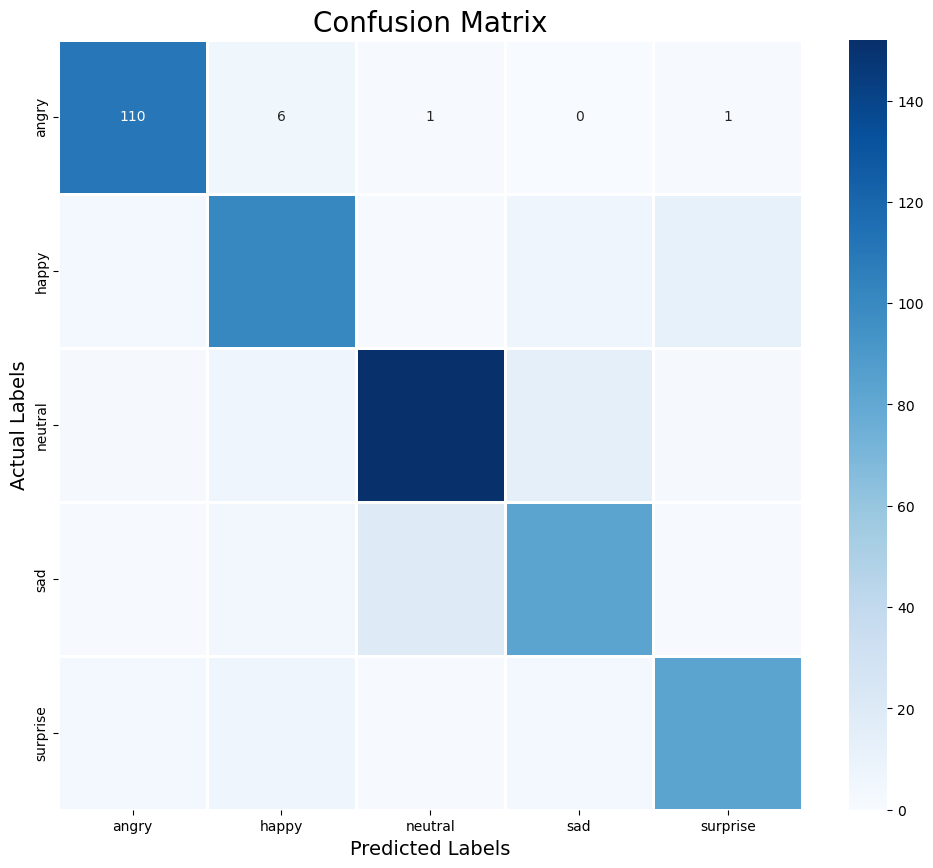

In [40]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.93      0.92       118
       happy       0.80      0.81      0.81       124
     neutral       0.87      0.86      0.87       177
         sad       0.78      0.76      0.77       109
    surprise       0.84      0.85      0.84        98

    accuracy                           0.85       626
   macro avg       0.84      0.84      0.84       626
weighted avg       0.84      0.85      0.84       626



In [42]:
model.save('emotion-audio.keras')

In [43]:
import joblib

joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']